In [1]:
import os, math
from collections import defaultdict, namedtuple
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_1024'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [3]:
%run sequencing_sp.ipynb

In [4]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'sim'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [5]:
hdc = Hdc(10_000, xp)

In [6]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.29 μs


((100, 5), (20, 5))


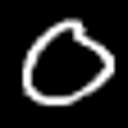
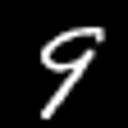
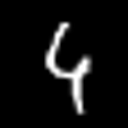
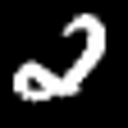
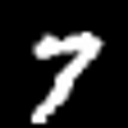
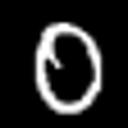
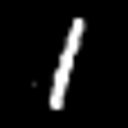
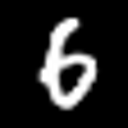
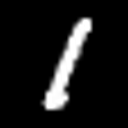
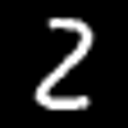
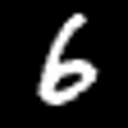
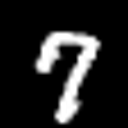
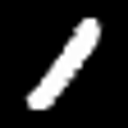
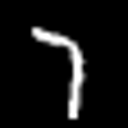
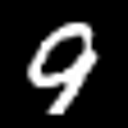
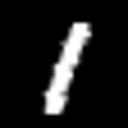

In [7]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [78]:
class Engram(object):
    def __init__(self):
        self.roles = pd.DataFrame(columns=['tag', 'vec'])
        self.relations = pd.DataFrame(columns=['rel_mnem', 'lp', 'rp', 'rel_val']) 

In [79]:
class RelationValue(StrEnum):
    NA = auto()
    
    WHERE_IN_FRONT = auto()
    WHERE_TO_THE_LEFT = auto()
    WHERE_TO_THE_RIGHT = auto()
    WHERE_BEHIND = auto() 

    LEN_EQ = auto()
    LEN_SHORTER = auto()
    LEN_LONGER = auto()
    LEN_MUCH_SHORTER = auto()
    LEN_MUCH_LONGER = auto()

In [80]:
def calc_desired_rels_count(roles_count, si_count):
    l = 0.01
    b = 1.1 + l * math.exp(-l * si_count)
    y = math.log(roles_count, b)
    return int(y)

In [99]:
COS_SIM_45 = np.sqrt(2) / 2

class RelationCalc(StrEnum):
    WHERE = auto()
    LEN = auto()

    @staticmethod
    def calc_where_relation(lp, rp):
        assert len(lp) > 0, len(lp)
        assert len(rp) > 0, len(rp)
        lp = lp[0]
        rp = rp[0]
        between_vec = rp.x - lp.x, rp.y - lp.y
        lp_normal_vec = lp.normal_vec.real, lp.normal_vec.imag
        dp = between_vec[0] * lp_normal_vec[0] + between_vec[1] * lp_normal_vec[1]
        cos_sim = dp / (np.linalg.norm(between_vec) * 1) # ... * 1) - since normal_vec is already normalized

        if cos_sim > COS_SIM_45:
            return RelationValue.WHERE_IN_FRONT
        elif cos_sim < -COS_SIM_45:
            return RelationValue.WHERE_BEHIND
            
        normal_diff = get_angle_diff(lp.normal, np.angle(complex(between_vec[0], between_vec[1]), deg=True))

        if normal_diff > 45:
            return RelationValue.WHERE_TO_THE_LEFT
        else:
            return RelationValue.WHERE_TO_THE_RIGHT
    
    def calc_len_relation(lp, rp):
        assert len(lp) > 1, len(lp)
        assert len(rp) > 1, len(rp)
        l_segment_len = np.linalg.norm(lp[1].x - lp[0].x, lp[1].y - lp[0].y)
        r_segment_len = np.linalg.norm(rp[1].x - rp[0].x, rp[1].y - rp[0].y)
    
        if np.isclose(l_segment_len, 0) and np.isclose(r_segment_len, 0):
            return RelationValue.NA
    
        if l_segment_len < r_segment_len:
            ratio = l_segment_len / r_segment_len
    
            if ratio >= 0.8:
                return RelationValue.LEN_EQ
            elif ratio >= 0.2:
                return RelationValue.LEN_SHORTER
            else:
                return RelationValue.LEN_MUCH_SHORTER
        else:
            ratio = r_segment_len / l_segment_len
    
            if ratio >= 0.8:
                return RelationValue.LEN_EQ
            elif ratio >= 0.2:
                return RelationValue.LEN_LONGER
            else:
                return RelationValue.LEN_MUCH_LONGER

    @staticmethod
    def calc(mnem, lp, rp):
        match mnem:
            case RelationCalc.WHERE: 
                return RelationCalc.calc_where_relation(lp, rp)
            case RelationCalc.LEN: 
                return RelationCalc.calc_len_relation(lp, rp)
            case _:
                assert False

In [49]:
image_index = RNG.choice(df_train_images.index)
# image_index = 10710
df_image = df_train_images.loc[image_index]

In [102]:
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences = simplify_sequences(sensor_instance_ind_dict, sequences_full, ma_window_size=4, precision=15)
sequences_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences]

si_flat_list = list(itertools.chain.from_iterable(sequences_si))
si_count = len(si_flat_list)
where_roles_count = math.comb(si_count, 2) # si_count * (si_count - 1) // 2
len_roles_count = math.comb(where_roles_count, 2) # where_roles_count * (where_roles_count - 1) // 2 

where_rels_count = calc_desired_rels_count(where_roles_count, si_count)
len_rels_count = calc_desired_rels_count(len_roles_count, si_count)

# si_count, where_rels_count, len_rels_count

RNG.shuffle(si_flat_list)

In [103]:
engram = Engram()
engram_relations = defaultdict(list)
engram_roles = set()

# for (lp, rp), _ in zip(itertools.combinations(si_flat_list, 2), range(where_rels_count)): ЖОПА itertools.combinations сначала обрабатывает первую
for (lp, rp), _ in zip(itertools.combinations(si_flat_list, 2), range(where_rels_count)): 
    assert lp.Index != rp.Index
    rel_val = RelationCalc.calc(RelationCalc.WHERE, [lp], [rp])

    if rel_val == RelationValue.NA:
        continue
        
    engram_relations['rel_mnem'].append(RelationCalc.WHERE)
    engram_relations['rel_val'].append(rel_val)
    engram_relations['lp'].append([lp.Index])
    engram_relations['rp'].append([rp.Index])
    
    engram_roles.add(lp)
    engram_roles.add(rp)

engram.relations = pd.concat([engram.relations, pd.DataFrame(engram_relations)])

In [104]:
engram.relations.head(10)

,rel_mnem,lp,rp,rel_val
0,where,[229],[257],where_behind
1,where,[229],[254],where_to_the_right
2,where,[229],[111],where_behind
3,where,[229],[550],where_to_the_right
4,where,[229],[181],where_behind
5,where,[229],[496],where_to_the_right
6,where,[229],[46],where_behind
7,where,[229],[114],where_behind
8,where,[229],[558],where_to_the_right
9,where,[229],[271],where_behind



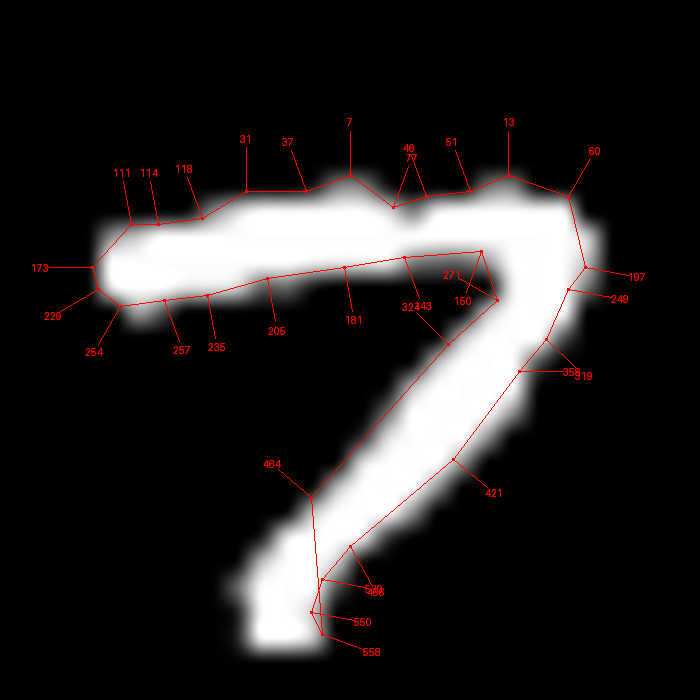

In [54]:
image_png = df_image['png']
image = Image.open(io.BytesIO(image_png))
image = image.convert('RGB')
k = image.size[0]
image = image.resize((700, 700))
k = image.size[0] / k
image_draw = ImageDraw.Draw(image)

for seq in sequences_si:
    for si_from, si_to in zip(seq, seq[1:] + [seq[0]]):
        pt_from = si_from.x * k, si_from.y * k
        pt_to = si_to.x * k, si_to.y * k
        image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')

        nl = 8 * k
        image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
        normal_vec = si_from.normal_vec
        image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
        image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_from.Index), anchor='mm', fill='red')

        image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
        normal_vec = si_to.normal_vec
        image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
        image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_to.Index), anchor='mm', fill='red')

display_images([image], captions=[f'{image_index}, {df_image['value']}'])

In [ ]:
ENGRAMS = []

In [ ]:
assert False

In [9]:
%%time

train_runs = 2 * 50
attempts_to_get_no_mistakes = 10
count = min(1000, len(df_train_images))
consolidation_threshold = 1000

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    
    for column_id, column in COLUMN_HOSTS.items():
        column.train_start(TRAIN_RUN_ID, image_ids, consolidation_threshold, attempts_to_get_no_mistakes)

    for column_id, column in COLUMN_HOSTS.items():
        column.train_finish()

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1.34 s, sys: 778 ms, total: 2.12 s
Wall time: 1h 2min 27s


In [18]:
# TEST RUN
TEST_RUN_ID += 1
count = min(2000, len(test_run_source[0]))
# test_run_source = (df_test_images, test_db_con, 'test')
test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
column_id_whitelist = COLUMN_HOSTS.keys()
# column_id_whitelist = [3]
assert np.all(np.array(list(map(lambda i: i in COLUMN_HOSTS, column_id_whitelist))) == 1)

for image_id in tqdm(test_image_ids):
    image_value = test_run_source[0].loc[image_id]['value']
    column_votes_vectors = []
    column_votes_vector = np.zeros(10)
    column_images_seen = {}
    
    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_host.infer_start(image_id, test_run_source[2])

    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_votes_vector_, column_images_seen_ = column_host.infer_finish()
        column_votes_vector += column_votes_vector_
        column_votes_vectors.append(column_votes_vector_)
        column_images_seen.update(column_images_seen_)

    infer_value = ''
    
    if np.any(column_votes_vector) > 0:
        # digit_probabilities = softmax(column_votes_vector)
        # infer_value = str(RNG.choice(10, p=digit_probabilities))
        infer_value = str(np.argmax(column_votes_vector)) # softmax([0,0,0,0,0,0,0,0,0,4]) will produce probs [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.9]
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(sorted(column_id_whitelist))
    test_result_rows['train_images_count'].append(max(list(column_images_seen.values())))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value) 
    test_result_rows['sim'].append(np.array(column_votes_vectors))
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

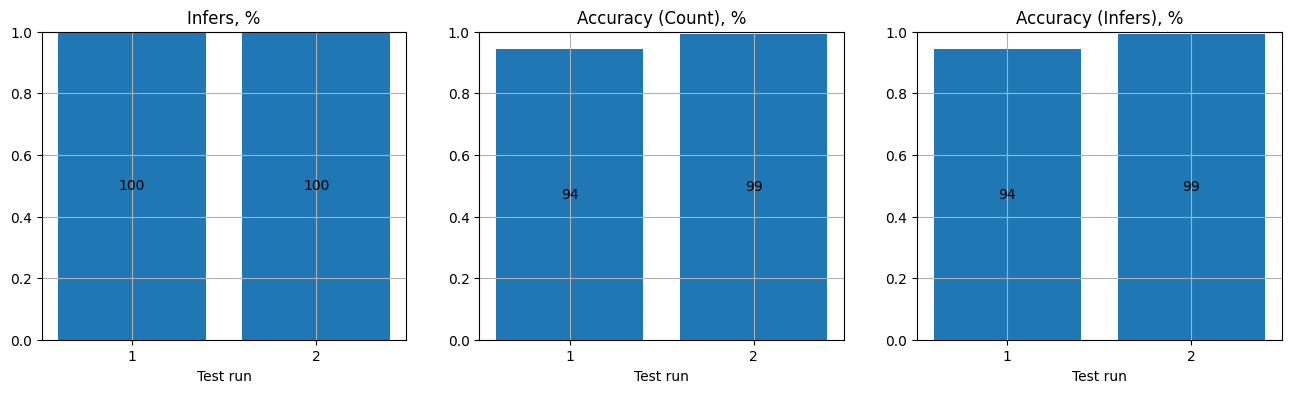

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,test,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,2000,2000,1890,1.0,0.945,0.945
2,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,train,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,2000,2000,1988,1.0,0.994,0.994


In [19]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [15]:
df = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == 1]
df_incorrect = df.loc[df.true_value != df.infer_value]
df_incorrect

,test_run_id,config_variant,cortical_columns,train_images_count,train_runs,source_ds,test_image_id,true_value,infer_value,sim
30,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100002770,3,7,"[[0.0, 0.0, 0.0, 0.46877893452284713, 0.0, 0.0..."
35,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100002771,4,9,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
36,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100003954,8,9,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
46,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100003941,4,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.522401601666..."
66,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100000998,8,7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5408307..."
...,...,...,...,...,...,...,...,...,...,...
1872,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100009669,4,7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6176946..."
1895,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100008520,4,9,"[[0.0, 0.0, 0.0, 0.0, 0.6496902371613007, 0.0,..."
1911,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100004437,3,2,"[[0.0, 0.0, 0.0, 0.5849986534312511, 0.0, 0.0,..."
1918,1,SQLITE3_EXNORMAL_GRID_RADIAL_11_256,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",115045,100,test,100009782,6,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.568141462487..."
